In [187]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, confusion_matrix, recall_score, precision_score
from sklearn.preprocessing import binarize, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt


Functions

In [188]:
def encoder(dataset, catFeatures, qtyFeatures):
  dataset = dataset[catFeatures + qtyFeatures]
  dataset_encoded = pd.get_dummies(dataset, 
                                   columns = catFeatures, 
                                   drop_first = True)
  
  return(dataset_encoded)

def plot_auc_curve(model, X, y):
  try:
      y_pred_prob = model.predict_proba(X)[:,1]
  except:
    d = model.decision_function(X)
    y_pred_prob = np.exp(d) / (1 + np.exp(d))
  
  auc = roc_auc_score(y, y_pred_prob)
  fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
  
  plt.plot(fpr, tpr)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.title('ROC Curve\n AUC={auc}'.format(auc = auc))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.grid(True)

def model_training(model, X, y):
  model.fit(X,y)
  
  return(model)

def print_accuracy_metrics(model, X, y, threshold):
    try:
        y_pred_prob = model.predict_proba(X)[:, 1]
    except AttributeError:
        d = model.decision_function(X)
        y_pred_prob = np.exp(d) / (1 + np.exp(d))
    
    y_pred_class = (y_pred_prob >= threshold).astype(int)
    
    print("Accuracy:", accuracy_score(y, y_pred_class))
    print("AUC:", roc_auc_score(y, y_pred_prob))
    print("Log Loss:", log_loss(y, y_pred_prob))
    print("Confusion Matrix:\n", confusion_matrix(y, y_pred_class))
    print("Recall:", recall_score(y, y_pred_class))
    print("Precision:", precision_score(y, y_pred_class))


def Find_Optimal_Cutoff(model, X, y):
  try:
    y_pred_prob = model.predict_proba(X)[:,1]
  except:
    d = model.decision_function(X)
    y_pred_prob = np.exp(d) / (1 + np.exp(d))
    
  fpr, tpr, threshold = roc_curve(y, y_pred_prob)
  i = np.arange(len(tpr)) 
  roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
  roc_t = roc.loc[(roc.tf-0).abs().argsort()[:1]]
  
  print("Optimal Cutoff:", roc_t['threshold'].values)
  return(roc_t['threshold'].values)
  
def feature_importance(model, X):
  importances = model.feature_importances_
  std = np.std([tree.feature_importances_ for tree in model.estimators_],
               axis=0)
  indices = np.argsort(importances)[::-1]

  # Print the feature ranking
  print("Feature ranking:")

  for f in range(X.shape[1]):
      print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

  # Plot the feature importances of the forest
  plt.figure()
  plt.title("Feature importances")
  plt.bar(range(X.shape[1]), importances[indices],
          color="r", yerr=std[indices], align="center")
  plt.xticks(range(X.shape[1]), indices)
  plt.xlim([-1, X.shape[1]])
  plt.show()

# Plot calibration plots
def plot_calibration(y_true, y_prob, n_bins, model_name):
  plt.figure(figsize=(10, 10))
  ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
  ax2 = plt.subplot2grid((3, 1), (2, 0))

  ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
  fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_true, y_prob, n_bins=n_bins)

  ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (model_name, ))

  ax2.hist(y_pred_prob, range=(0, 1), bins=10, label=model_name,
             histtype="step", lw=2)

  ax1.set_ylabel("Fraction of positives")
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend(loc="lower right")
  ax1.set_title('Calibration plots')

  ax2.set_xlabel("Mean predicted value")
  ax2.set_ylabel("Count")
  ax2.legend(loc="upper right", ncol=2)

  plt.tight_layout()
  plt.show()

Confusion Matrix

first argument is actual values, second argument is predicted values
Precision:

When a positive value is predicted, how often is the prediction correct?
How "precise" is the classifier when predicting positive instances?
Recall

Calculate TP rate or recall
Pandas

use the pandas library to read data into Python

In [189]:
file_url ='https://drive.google.com/uc?export=download&id=13YvNpCckww8rNdLGxAh0tekdsehXI0HU'
df = pd.read_csv(file_url)

In [190]:
df.head()

,Loan_ID,Customer_ID,Loan_Status,Current_Loan_Amount,Term,Credit_Score,Years_in_current_job,Home_Ownership,Annual_Income,Purpose,Monthly_Debt,Years_of_Credit_History,Months_since_last_delinquent,Number_of_Open_Accounts,Number_of_Credit_Problems,Current_Credit_Balance,Maximum_Open_Credit,Bankruptcies,Tax_Liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Charged Off,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Charged Off,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961,0.0,0.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Charged Off,16117,Short Term,7240.0,9 years,Home Mortgage,60438.0,Home Improvements,"1,244.02",16.7,32.0,11,1,11275,14815,1.0,0.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Charged Off,11716,Short Term,7400.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533,0.0,0.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Charged Off,9789,Long Term,6860.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0


In [191]:
df.shape

(111105, 19)

In [192]:
df.dtypes

Loan_ID                          object
Customer_ID                      object
Loan_Status                      object
Current_Loan_Amount               int64
Term                             object
Credit_Score                    float64
Years_in_current_job             object
Home_Ownership                   object
Annual_Income                   float64
Purpose                          object
Monthly_Debt                     object
Years_of_Credit_History         float64
Months_since_last_delinquent    float64
Number_of_Open_Accounts           int64
Number_of_Credit_Problems         int64
Current_Credit_Balance            int64
Maximum_Open_Credit               int64
Bankruptcies                    float64
Tax_Liens                       float64
dtype: object

Use the describe method to generates descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values

In [193]:
df.describe()

,Current_Loan_Amount,Credit_Score,Annual_Income,Years_of_Credit_History,Months_since_last_delinquent,Number_of_Open_Accounts,Number_of_Credit_Problems,Current_Credit_Balance,Maximum_Open_Credit,Bankruptcies,Tax_Liens
count,1.111050e+05,89768.000000,8.976800e+04,111105.000000,52102.000000,111105.000000,111105.000000,1.111050e+05,1.111050e+05,110877.000000,111094.000000
mean,1.147739e+07,1075.728701,7.248575e+04,18.200991,34.902403,11.125197,0.168030,1.548342e+04,3.438644e+04,0.117662,0.029354
std,3.185533e+07,1474.007753,5.593120e+04,7.014542,21.971081,5.010249,0.484216,1.982122e+04,3.643027e+05,0.351423,0.260577
min,4.910000e+02,585.000000,4.033000e+03,3.600000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,8.162000e+03,705.000000,4.468750e+04,13.500000,16.000000,8.000000,0.000000,5.905000e+03,1.241700e+04,0.000000,0.000000
50%,1.418300e+04,724.000000,6.175200e+04,16.900000,32.000000,10.000000,0.000000,1.102700e+04,2.124300e+04,0.000000,0.000000
75%,2.382200e+04,741.000000,8.688700e+04,21.700000,51.000000,14.000000,0.000000,1.933800e+04,3.558400e+04,0.000000,0.000000
max,1.000000e+08,7510.000000,8.713547e+06,70.500000,176.000000,76.000000,15.000000,1.730472e+06,6.998809e+07,7.000000,15.000000


In [194]:
df.loc[((df['Credit_Score'] > 850) & 
        (df['Credit_Score'] < 300)), 'Credit_Score'] = np.nan

Count the number of NA values for each variable

In [195]:
df.isnull().sum()

Loan_ID                             0
Customer_ID                         0
Loan_Status                         0
Current_Loan_Amount                 0
Term                                0
Credit_Score                    21337
Years_in_current_job             4693
Home_Ownership                      0
Annual_Income                   21337
Purpose                             0
Monthly_Debt                        0
Years_of_Credit_History             0
Months_since_last_delinquent    59003
Number_of_Open_Accounts             0
Number_of_Credit_Problems           0
Current_Credit_Balance              0
Maximum_Open_Credit                 0
Bankruptcies                      228
Tax_Liens                          11
dtype: int64

In [196]:
df.groupby('Loan_Status')['Loan_ID'].count()

Loan_Status
Charged Off    25171
Fully Paid     85934
Name: Loan_ID, dtype: int64

In [197]:
loanIDCount = df.groupby('Loan_ID')['Loan_Status'].count()
loanIDCount = loanIDCount.sort_values(ascending = False)
loanIDCount[0:5]

Loan_ID
ffffe32e-ed17-459f-9cfd-7b9ee7972933    2
4d6ad857-0421-447a-9328-816bbabd2139    2
4e0a83ad-4055-4a11-b3c8-e158a08db278    2
4e07ca4f-abcd-454f-a2f1-4e55b5fefaf0    2
4e049f22-78f9-4230-ac53-2c98745cf76c    2
Name: Loan_Status, dtype: int64

Checking for the duplicate LOAN_ID

In [198]:

df[df['Loan_ID'] == 'ffffe32e-ed17-459f-9cfd-7b9ee7972933']

,Loan_ID,Customer_ID,Loan_Status,Current_Loan_Amount,Term,Credit_Score,Years_in_current_job,Home_Ownership,Annual_Income,Purpose,Monthly_Debt,Years_of_Credit_History,Months_since_last_delinquent,Number_of_Open_Accounts,Number_of_Credit_Problems,Current_Credit_Balance,Maximum_Open_Credit,Bankruptcies,Tax_Liens
78728,ffffe32e-ed17-459f-9cfd-7b9ee7972933,97281336-1e45-41d2-acb2-263ce56a590e,Fully Paid,27902,Long Term,678.0,10+ years,Home Mortgage,117480.0,Debt Consolidation,"2,525.82",18.0,11.0,10,0,28317,62371,0.0,0.0
111027,ffffe32e-ed17-459f-9cfd-7b9ee7972933,97281336-1e45-41d2-acb2-263ce56a590e,Fully Paid,27902,Long Term,678.0,10+ years,Home Mortgage,117480.0,Debt Consolidation,"2,525.82",18.0,11.0,10,0,28317,62371,0.0,0.0


Remove duplicates

In [199]:
df.drop_duplicates(inplace = True)

In [200]:
df.shape

(98579, 19)

In [201]:
loanIDCount = df.groupby('Loan_ID')['Loan_Status'].count()
loanIDCount = loanIDCount.sort_values(ascending = False)
loanIDCount[0:5]

Loan_ID
bc609460-6bca-402c-a49f-90d869805cf7    2
763eb146-e045-44fc-b914-669a99c0e27b    2
9616bc3b-392d-4ae6-9c6b-50373450f987    2
c85df7c1-7908-449d-b77f-d6cbe089054b    2
9617dabf-60cc-4a27-b5a5-c53c31a1dbfe    2
Name: Loan_Status, dtype: int64

In [202]:
df[df['Loan_ID'] == '7f85733b-ef51-48e5-a0a2-1a7b68492d4e']

,Loan_ID,Customer_ID,Loan_Status,Current_Loan_Amount,Term,Credit_Score,Years_in_current_job,Home_Ownership,Annual_Income,Purpose,Monthly_Debt,Years_of_Credit_History,Months_since_last_delinquent,Number_of_Open_Accounts,Number_of_Credit_Problems,Current_Credit_Balance,Maximum_Open_Credit,Bankruptcies,Tax_Liens
27947,7f85733b-ef51-48e5-a0a2-1a7b68492d4e,bc89f7d9-b603-41ee-9497-a40752183ae9,Fully Paid,11887,Short Term,NaN,4 years,Home Mortgage,NaN,Debt Consolidation,"1,287.70",16.6,26.0,11,0,32953,35471,0.0,0.0
100165,7f85733b-ef51-48e5-a0a2-1a7b68492d4e,bc89f7d9-b603-41ee-9497-a40752183ae9,Fully Paid,11887,Short Term,701.0,4 years,Home Mortgage,188214.0,Debt Consolidation,"1,287.70",16.6,26.0,11,0,32953,35471,0.0,0.0


In [203]:
df['naCount'] = df.isnull().sum(axis=1)

In [204]:
df.sort_values(by=['Loan_ID', 'naCount'], inplace = True)

In [205]:
df.drop_duplicates(subset=['Loan_ID'], keep = 'first', inplace = True)

In [206]:
loanIDCount = df.groupby('Loan_ID')['Loan_Status'].count()
loanIDCount = loanIDCount.sort_values(ascending = False)
loanIDCount[0:5]

Loan_ID
0000757f-a121-41ed-b17b-162e76647c1f    1
aa4ec5b8-69c5-482d-a999-b03f3f4ebd60    1
aa52d132-d9af-4482-9ca0-1bd99f6f4998    1
aa529316-dbac-48cf-9be0-96e68be3dadc    1
aa51f419-00a2-4445-a284-34f5b1cdc2d2    1
Name: Loan_Status, dtype: int64

In [207]:
print(len(df['Loan_ID'].unique()))
print(df.shape)

88908
(88908, 20)


In [208]:
df.isnull().sum()

Loan_ID                             0
Customer_ID                         0
Loan_Status                         0
Current_Loan_Amount                 0
Term                                0
Credit_Score                    16088
Years_in_current_job             3817
Home_Ownership                      0
Annual_Income                   16088
Purpose                             0
Monthly_Debt                        0
Years_of_Credit_History             0
Months_since_last_delinquent    48506
Number_of_Open_Accounts             0
Number_of_Credit_Problems           0
Current_Credit_Balance              0
Maximum_Open_Credit                 0
Bankruptcies                      192
Tax_Liens                           8
naCount                             0
dtype: int64

In [209]:
yearsInCurrentJobCount = df.groupby('Years_in_current_job')['Loan_ID'].count()
yearsInCurrentJobCount = yearsInCurrentJobCount.sort_values(ascending = False)
yearsInCurrentJobCount

Years_in_current_job
10+ years    27409
2 years       8186
< 1 year      7312
3 years       7263
5 years       6084
1 year        5765
4 years       5474
6 years       5095
7 years       4943
8 years       4098
9 years       3462
Name: Loan_ID, dtype: int64

Rounding off the columns


In [210]:
df.loc[(df['Years_in_current_job'] == '< 1 year'), 'Years_in_current_job'] = 0.5
df.loc[(df['Years_in_current_job'] == '1 year'), 'Years_in_current_job'] = 1
df.loc[(df['Years_in_current_job'] == '2 years'), 'Years_in_current_job'] = 2
df.loc[(df['Years_in_current_job'] == '3 years'), 'Years_in_current_job'] = 3
df.loc[(df['Years_in_current_job'] == '4 years'), 'Years_in_current_job'] = 4
df.loc[(df['Years_in_current_job'] == '5 years'), 'Years_in_current_job'] = 5
df.loc[(df['Years_in_current_job'] == '6 years'), 'Years_in_current_job'] = 6
df.loc[(df['Years_in_current_job'] == '7 years'), 'Years_in_current_job'] = 7
df.loc[(df['Years_in_current_job'] == '8 years'), 'Years_in_current_job'] = 8
df.loc[(df['Years_in_current_job'] == '9 years'), 'Years_in_current_job'] = 9
df.loc[(df['Years_in_current_job'] == '10+ years'), 'Years_in_current_job'] = 10

In [211]:
df['Years_in_current_job'] = df['Years_in_current_job'].astype('float')

In [212]:
monthlyDebtCount = df.groupby('Monthly_Debt')['Loan_ID'].count()
monthlyDebtCount = monthlyDebtCount.sort_values(ascending = False)
monthlyDebtCount

Monthly_Debt
0         69
775.08     8
560.42     7
984.75     7
837        7
          ..
163.84     1
163.85     1
163.88     1
163.91     1
999.95     1
Name: Loan_ID, Length: 70063, dtype: int64

Convert number strings with commas to float


In [213]:
df["Monthly_Debt"] = df["Monthly_Debt"].str.replace(",","").astype(float)
df['Monthly_Debt'] = df['Monthly_Debt'].astype('float')

In [214]:
df.dtypes

Loan_ID                          object
Customer_ID                      object
Loan_Status                      object
Current_Loan_Amount               int64
Term                             object
Credit_Score                    float64
Years_in_current_job            float64
Home_Ownership                   object
Annual_Income                   float64
Purpose                          object
Monthly_Debt                    float64
Years_of_Credit_History         float64
Months_since_last_delinquent    float64
Number_of_Open_Accounts           int64
Number_of_Credit_Problems         int64
Current_Credit_Balance            int64
Maximum_Open_Credit               int64
Bankruptcies                    float64
Tax_Liens                       float64
naCount                           int64
dtype: object

In [215]:
df.isnull().sum()

Loan_ID                             0
Customer_ID                         0
Loan_Status                         0
Current_Loan_Amount                 0
Term                                0
Credit_Score                    16088
Years_in_current_job             3817
Home_Ownership                      0
Annual_Income                   16088
Purpose                             0
Monthly_Debt                        0
Years_of_Credit_History             0
Months_since_last_delinquent    48506
Number_of_Open_Accounts             0
Number_of_Credit_Problems           0
Current_Credit_Balance              0
Maximum_Open_Credit                 0
Bankruptcies                      192
Tax_Liens                           8
naCount                             0
dtype: int64

Fill in missing values with mean

In [216]:
for f in ['Credit_Score', 
          'Years_in_current_job', 
          'Annual_Income', 
          'Months_since_last_delinquent',
          'Bankruptcies', 'Tax_Liens']:
  df.loc[df[f].isnull(), f] = df[f].mean()

In [217]:
df.isnull().sum()

Loan_ID                         0
Customer_ID                     0
Loan_Status                     0
Current_Loan_Amount             0
Term                            0
Credit_Score                    0
Years_in_current_job            0
Home_Ownership                  0
Annual_Income                   0
Purpose                         0
Monthly_Debt                    0
Years_of_Credit_History         0
Months_since_last_delinquent    0
Number_of_Open_Accounts         0
Number_of_Credit_Problems       0
Current_Credit_Balance          0
Maximum_Open_Credit             0
Bankruptcies                    0
Tax_Liens                       0
naCount                         0
dtype: int64

In [218]:
df.dtypes

Loan_ID                          object
Customer_ID                      object
Loan_Status                      object
Current_Loan_Amount               int64
Term                             object
Credit_Score                    float64
Years_in_current_job            float64
Home_Ownership                   object
Annual_Income                   float64
Purpose                          object
Monthly_Debt                    float64
Years_of_Credit_History         float64
Months_since_last_delinquent    float64
Number_of_Open_Accounts           int64
Number_of_Credit_Problems         int64
Current_Credit_Balance            int64
Maximum_Open_Credit               int64
Bankruptcies                    float64
Tax_Liens                       float64
naCount                           int64
dtype: object

In [219]:
qtyFeatures = ['Current_Loan_Amount', 
               'Credit_Score', 'Years_in_current_job', 
               'Annual_Income', 'Monthly_Debt', 
               'Years_of_Credit_History',
               'Months_since_last_delinquent', 'Number_of_Open_Accounts',
               'Current_Credit_Balance',
               'Maximum_Open_Credit', 
               'Number_of_Credit_Problems', 'Bankruptcies', 'Tax_Liens'
              ]

catFeatures = ['Term', 'Home_Ownership', 'Purpose']

label = 'Loan_Status'

In [220]:
df.groupby(['Home_Ownership'])['Loan_ID'].count()

Home_Ownership
HaveMortgage       170
Home Mortgage    43270
Own Home          8075
Rent             37393
Name: Loan_ID, dtype: int64

In [221]:
df.groupby(['Purpose'])['Loan_ID'].count()

Purpose
Business Loan            1328
Buy House                 559
Buy a Car                1196
Debt Consolidation      70445
Educational Expenses       92
Home Improvements        5206
Medical Bills             955
Other                    2850
Take a Trip               454
major_purchase            344
moving                    124
other                    4917
renewable_energy            9
small_business            248
vacation                   82
wedding                    99
Name: Loan_ID, dtype: int64

In [222]:
df.loc[(df['Purpose'] == 'other'), 'Purpose'] = 'Other' 

In [223]:
df['Loan_Status'].unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

Preparing X and y using pandas:

In [224]:
X_encoded = encoder(df, catFeatures, qtyFeatures)

le = LabelEncoder()
y_encoded = le.fit_transform(df[label])

In [225]:
X_encoded.head()

,Current_Loan_Amount,Credit_Score,Years_in_current_job,Annual_Income,Monthly_Debt,Years_of_Credit_History,Months_since_last_delinquent,Number_of_Open_Accounts,Current_Credit_Balance,Maximum_Open_Credit,...,Purpose_Home Improvements,Purpose_Medical Bills,Purpose_Other,Purpose_Take a Trip,Purpose_major_purchase,Purpose_moving,Purpose_renewable_energy,Purpose_small_business,Purpose_vacation,Purpose_wedding
49725,11731,746.000000,4.0,50025.000000,355.18,11.5,35.080466,12,17391,37081,...,False,False,False,False,False,False,False,False,False,False
20733,24613,1163.139371,6.0,72404.505136,542.29,17.6,73.000000,7,14123,16954,...,False,False,False,False,False,False,False,False,False,False
15639,99999999,742.000000,3.0,64760.000000,582.84,26.8,35.080466,11,8880,22711,...,False,False,False,False,False,False,False,False,False,False
68632,11863,734.000000,10.0,69202.000000,859.26,30.3,35.080466,7,9959,16995,...,False,False,False,False,False,False,False,False,False,False
97429,13719,724.000000,1.0,34297.000000,777.38,13.6,2.000000,12,6720,53335,...,True,False,False,False,False,False,False,False,False,False


In [226]:
y_encoded

array([1, 0, 1, ..., 0, 1, 1])

Spliting into train and test 

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, 
                                                    y_encoded, 
                                                    test_size = 0.2,
                                                    random_state = 1)

Optimal Cutoff: [0.68099598]
Accuracy: 0.7081880553368575
AUC: 0.7361655013704884
Log Loss: 0.47018593298957617
Confusion Matrix:
 [[ 2427  2580]
 [ 2609 10166]]
Recall: 0.7957729941291585
Precision: 0.7975835556252943


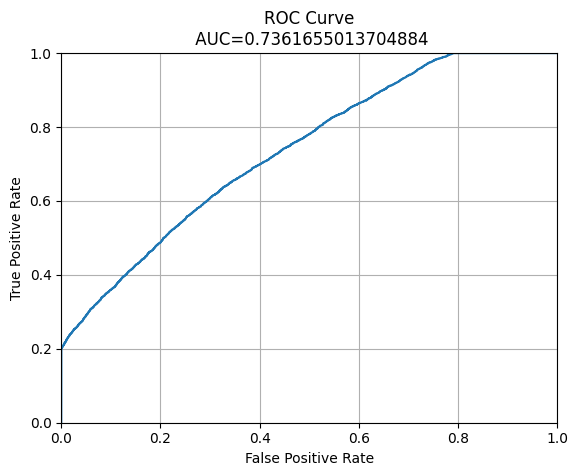

In [228]:
logreg = LogisticRegression()
model_training(logreg, X_train, y_train)

plot_auc_curve(logreg, X_test, y_test)
Find_Optimal_Cutoff(logreg, X_test, y_test)
print_accuracy_metrics(logreg, X_test, y_test, 0.65)

Optimal Cutoff: [0.68157585]
Accuracy: 0.7041306976351827
AUC: 0.7267504526148407
Log Loss: 0.4793327905286698
Confusion Matrix:
 [[ 9642 10522]
 [10522 40440]]
Recall: 0.7935324359326557
Precision: 0.7935324359326557


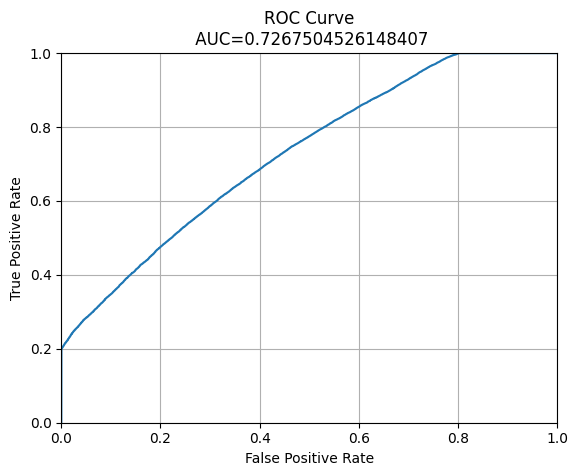

In [229]:
plot_auc_curve(logreg, X_train, y_train)
Find_Optimal_Cutoff(logreg, X_train, y_train)
print_accuracy_metrics(logreg, X_train, y_train, 0.65)

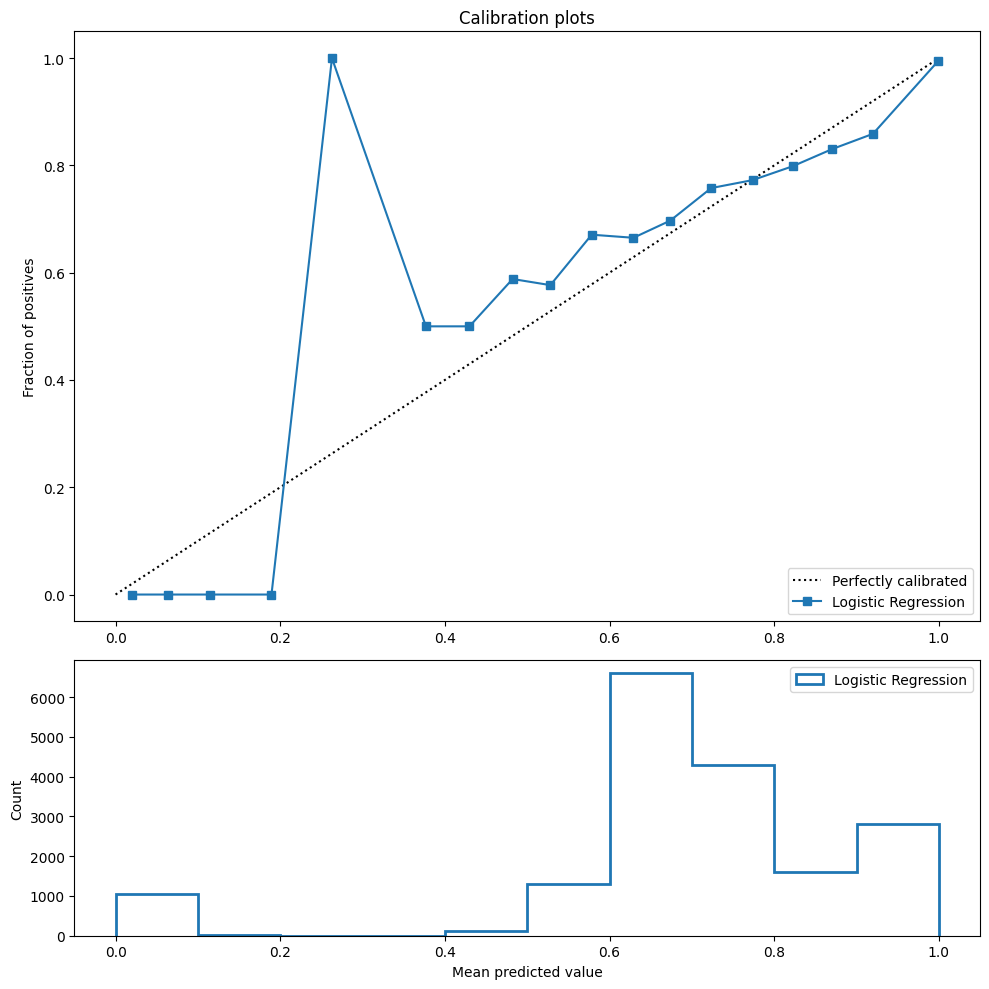

In [230]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

plot_calibration(y_test, y_pred_prob, 20, "Logistic Regression")

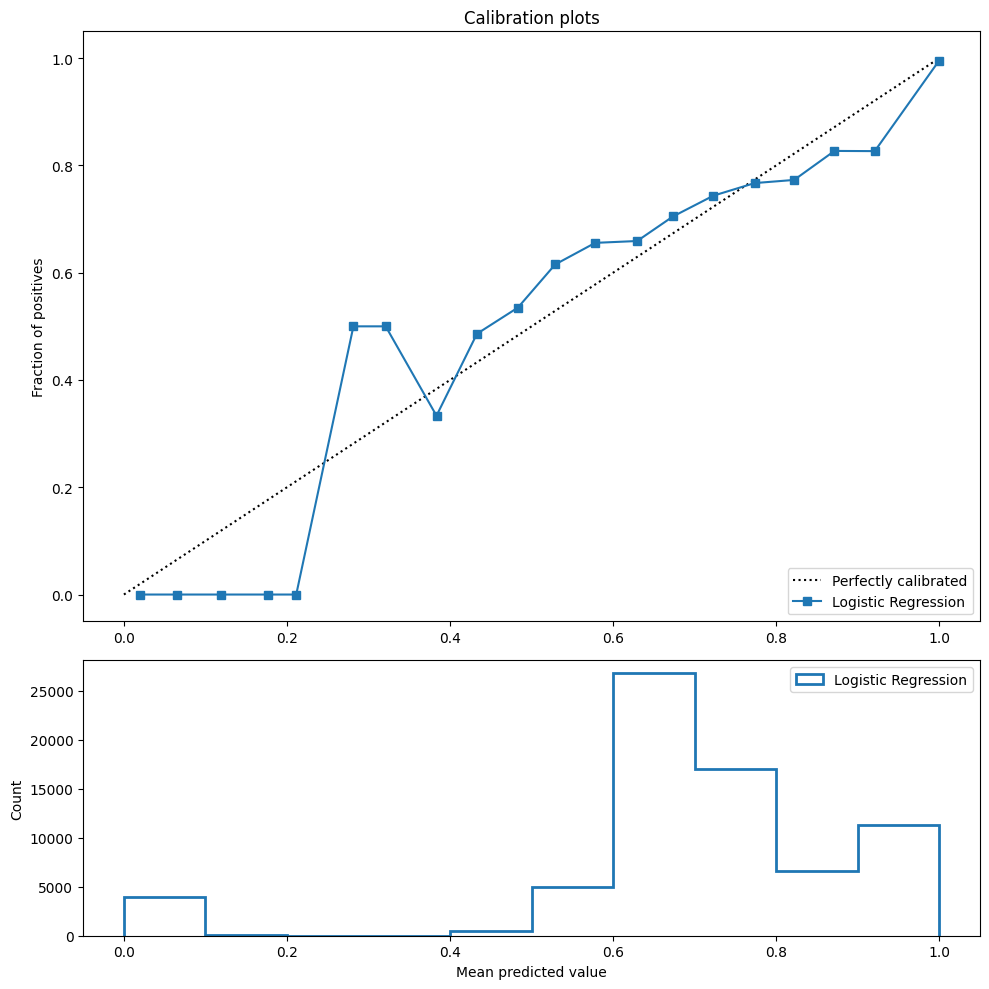

In [231]:
y_pred_prob = logreg.predict_proba(X_train)[:, 1]

plot_calibration(y_train, y_pred_prob, 20, "Logistic Regression")

In [232]:
print_accuracy_metrics(logreg, X_train, y_train, 0.65)

Accuracy: 0.7041306976351827
AUC: 0.7267504526148407
Log Loss: 0.4793327905286698
Confusion Matrix:
 [[ 9642 10522]
 [10522 40440]]
Recall: 0.7935324359326557
Precision: 0.7935324359326557


Fit Logistic regression with L2 regularization (Ridge)


Optimal Cutoff: [0.61143814]
Accuracy: 0.6916544820605106
AUC: 0.77472232416691
Log Loss: 0.5467745410996127
Confusion Matrix:
 [[3351 1656]
 [3827 8948]]
Recall: 0.7004305283757338
Precision: 0.8438325160316862


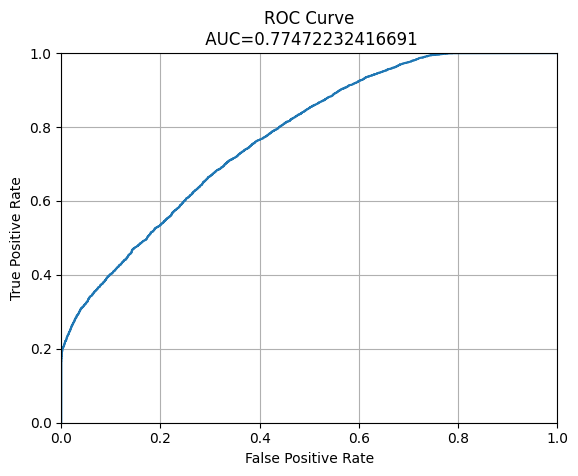

In [233]:
ridge = RidgeClassifier(alpha=1.0)
model_training(ridge, X_train, y_train)

plot_auc_curve(ridge, X_test, y_test)
Find_Optimal_Cutoff(ridge, X_test, y_test)
print_accuracy_metrics(ridge, X_test, y_test, 0.61)

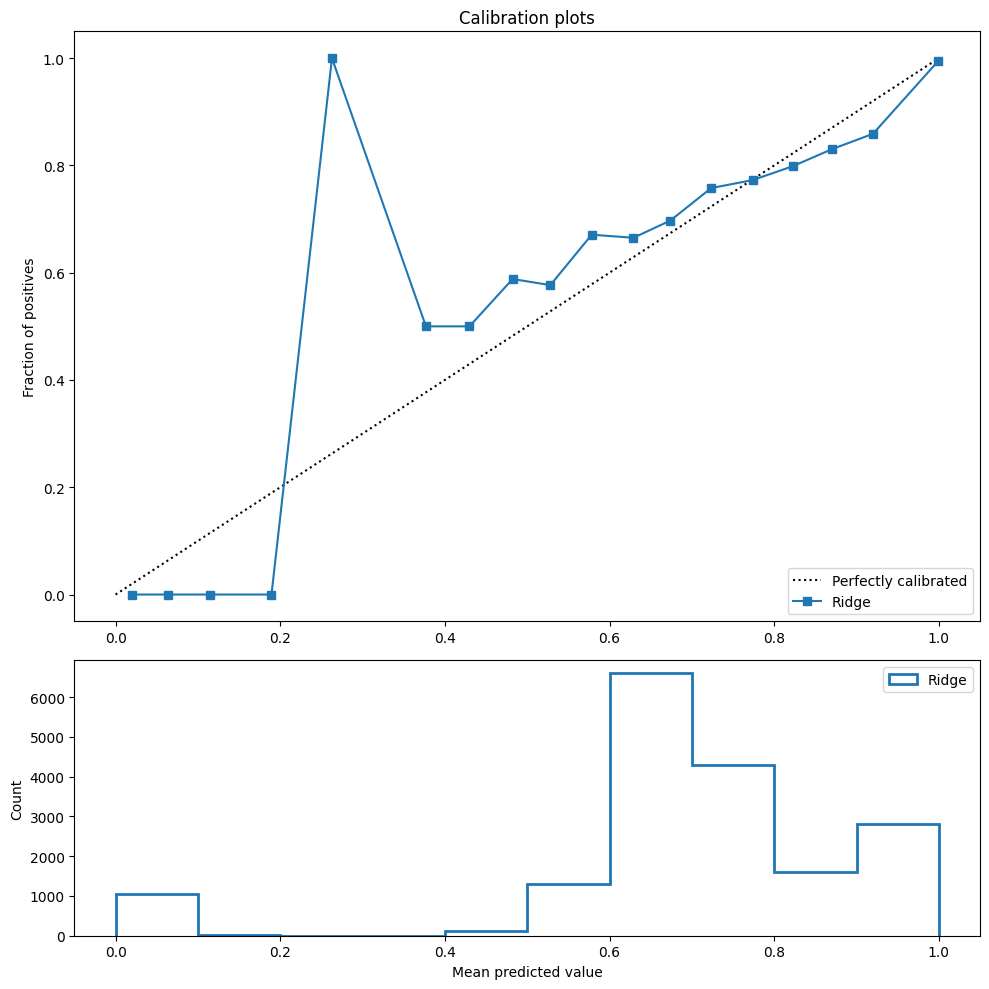

In [234]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

plot_calibration(y_test, y_pred_prob, 20, "Ridge")

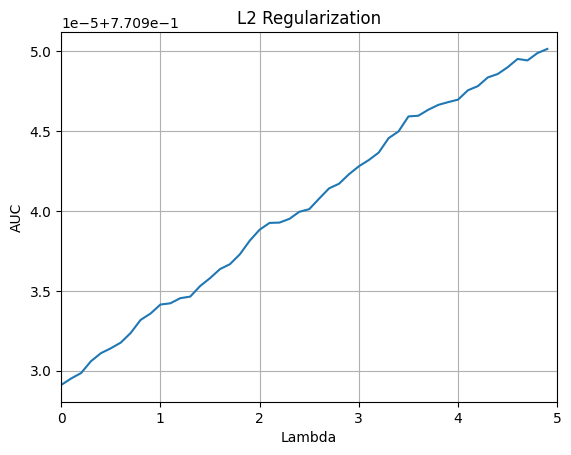

In [235]:
alpha_range = np.arange(0.001, 5, 0.1)
scores = []
for lam in alpha_range:
  ridge = RidgeClassifier(alpha=lam)
  scores.append(cross_val_score(ridge, X_train, y_train, cv=5, scoring='roc_auc').mean())

plt.plot(alpha_range, scores)
plt.xlim([0.0, 5])
#plt.ylim([0.0, 1.0])
plt.title('L2 Regularization')
plt.xlabel('Lambda')
plt.ylabel('AUC')
plt.grid(True)

In [236]:
scores

[0.7709291049340654,
 0.7709295087235807,
 0.7709298493495294,
 0.7709305937979971,
 0.7709310949309205,
 0.7709314014839289,
 0.7709317566590096,
 0.770932360013949,
 0.7709331774479482,
 0.7709335764405492,
 0.7709341408986766,
 0.770934218746931,
 0.7709345398442053,
 0.7709346371480457,
 0.7709352988946192,
 0.7709357951641695,
 0.7709363595877421,
 0.7709366660913974,
 0.7709372840011312,
 0.7709381403419929,
 0.7709388312662172,
 0.770939254601751,
 0.7709392740610367,
 0.7709395075871697,
 0.7709399503660374,
 0.7709401157582371,
 0.770940777473915,
 0.77094141972861,
 0.7709417067931612,
 0.7709423003891869,
 0.7709428015831982,
 0.7709431908467465,
 0.7709436579410991,
 0.7709445629306325,
 0.770944986251766,
 0.7709459253212276,
 0.7709459691304206,
 0.7709463437822238,
 0.7709466454425552,
 0.770946820552895,
 0.7709469762592025,
 0.7709475649956741,
 0.7709478228969214,
 0.7709483678420477,
 0.7709485819234146,
 0.7709490052174582,
 0.7709495258575484,
 0.7709494334039535,


Fit Logistic regression with L1 regularization (Lasso)

Optimal Cutoff: [0.72754968]
Accuracy: 0.6823191991901923
AUC: 0.7813864034578597
Log Loss: 0.4460483302759512
Confusion Matrix:
 [[3481 1526]
 [4123 8652]]
Recall: 0.6772602739726027
Precision: 0.8500687757909215


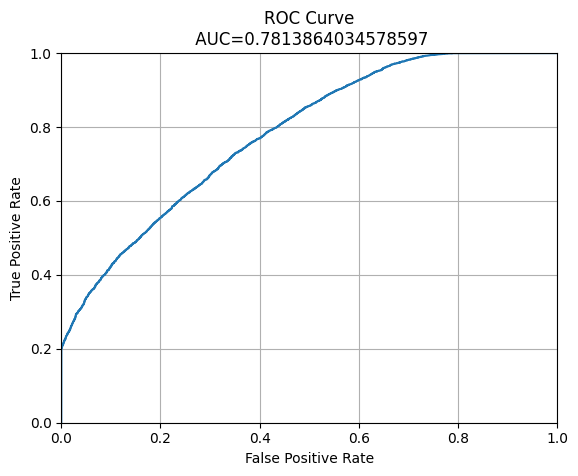

In [237]:
lasso = LogisticRegression(penalty='l1', C=1, solver='liblinear')
model_training(lasso, X_train, y_train)

plot_auc_curve(lasso, X_test, y_test)
Find_Optimal_Cutoff(lasso, X_test, y_test)
print_accuracy_metrics(lasso, X_test, y_test, 0.73)

In [238]:
lambda_range = np.arange(0.001, 5, 0.1)
scores = []
for lam in lambda_range:
  lasso = LogisticRegression(penalty='l1', C=1/lam, solver='liblinear')
  scores.append(cross_val_score(lasso, X_train, y_train, cv=5, scoring='roc_auc').mean())

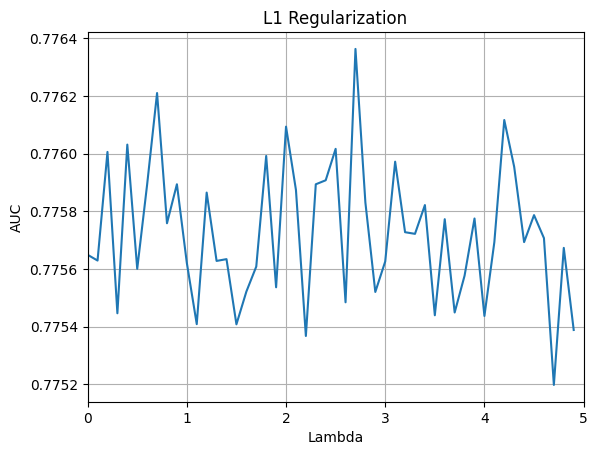

In [239]:
plt.plot(lambda_range, scores)
plt.xlim([0.0, 5])
#plt.ylim([0.0, 1.0])
plt.title('L1 Regularization')
plt.xlabel('Lambda')
plt.ylabel('AUC')
plt.grid(True)

2-degree Polynomial Features

In [240]:
poly = PolynomialFeatures(2)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

In [241]:
print(X_test.shape)
print(X_test_poly.shape)

(17782, 31)
(17782, 528)


Optimal Cutoff: [0.57943061]
Accuracy: 0.4513553031155101
AUC: 0.6238216790036024
Log Loss: 0.5600306385141582
Confusion Matrix:
 [[4768  239]
 [9517 3258]]
Recall: 0.2550293542074364
Precision: 0.9316557048899057


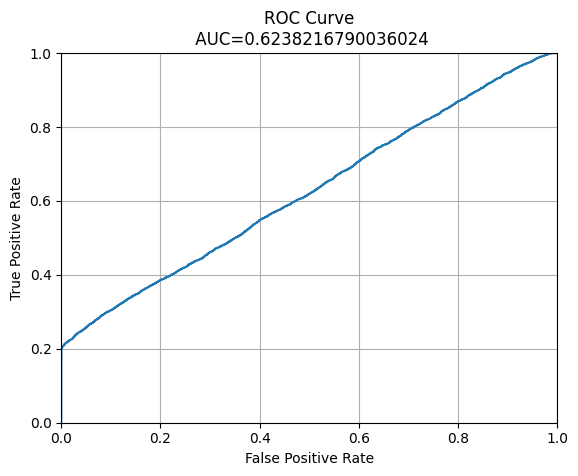

In [242]:
logreg_poly = LogisticRegression()
model_training(logreg_poly, X_train_poly, y_train)

plot_auc_curve(logreg_poly, X_test_poly, y_test)
Find_Optimal_Cutoff(logreg_poly, X_test_poly, y_test)
print_accuracy_metrics(logreg_poly, X_test_poly, y_test, 0.75)

Optimal Cutoff: [0.57897159]
Accuracy: 0.4544048589826505
AUC: 0.6251195837552656
Log Loss: 0.563051195636214
Confusion Matrix:
 [[19177   987]
 [37819 13143]]
Recall: 0.2578980416781131
Precision: 0.9301486199575372


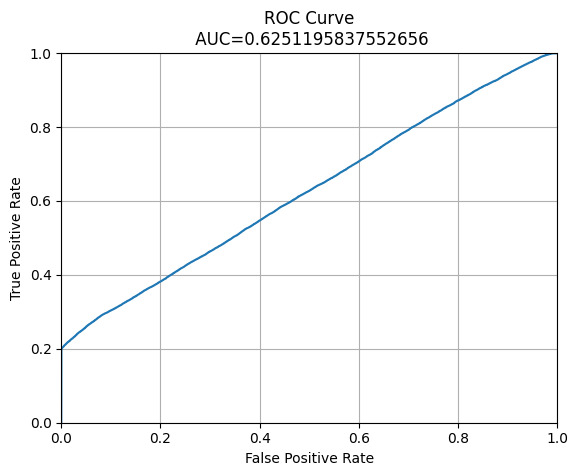

In [243]:
plot_auc_curve(logreg_poly, X_train_poly, y_train)
Find_Optimal_Cutoff(logreg_poly, X_train_poly, y_train)
print_accuracy_metrics(logreg_poly, X_train_poly, y_train, 0.75)

In [244]:
print_accuracy_metrics(logreg_poly, X_train_poly, y_train, 0.75)

Accuracy: 0.4544048589826505
AUC: 0.6251195837552656
Log Loss: 0.563051195636214
Confusion Matrix:
 [[19177   987]
 [37819 13143]]
Recall: 0.2578980416781131
Precision: 0.9301486199575372


Optimal Cutoff: [0.60662915]
Accuracy: 0.7075694522550894
AUC: 0.7855781397237604
Log Loss: 0.5413548047116213
Confusion Matrix:
 [[3265 1742]
 [3458 9317]]
Recall: 0.7293150684931506
Precision: 0.8424812370015372


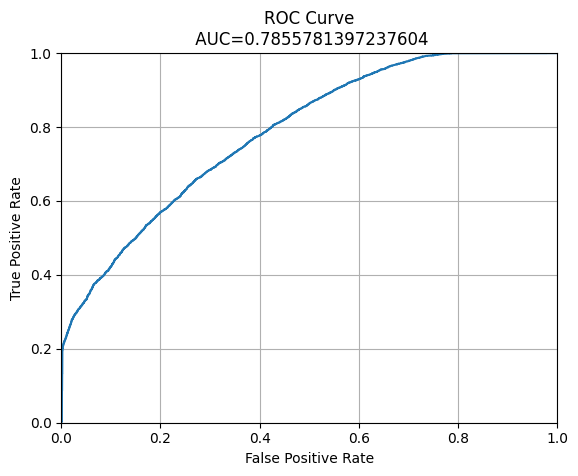

In [245]:
ridge_poly = RidgeClassifier(alpha=1.0)
model_training(ridge_poly, X_train_poly, y_train)

plot_auc_curve(ridge_poly, X_test_poly, y_test)
Find_Optimal_Cutoff(ridge_poly, X_test_poly, y_test)
print_accuracy_metrics(ridge_poly, X_test_poly, y_test, 0.6)

Optimal Cutoff: [0.72245121]
Accuracy: 0.6818693060398155
AUC: 0.7885496977421433
Log Loss: 0.44196066521893573
Confusion Matrix:
 [[3574 1433]
 [4224 8551]]
Recall: 0.6693542074363992
Precision: 0.8564703525641025


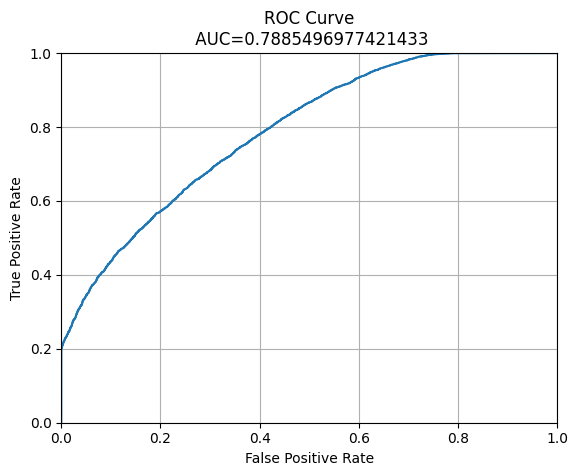

In [246]:
lasso_poly = LogisticRegression(penalty='l1', C=1,solver='liblinear')
model_training(lasso_poly, X_train_poly, y_train)

plot_auc_curve(lasso_poly, X_test_poly, y_test)
Find_Optimal_Cutoff(lasso_poly, X_test_poly, y_test)
print_accuracy_metrics(lasso_poly, X_test_poly, y_test, 0.73)

Random forrest

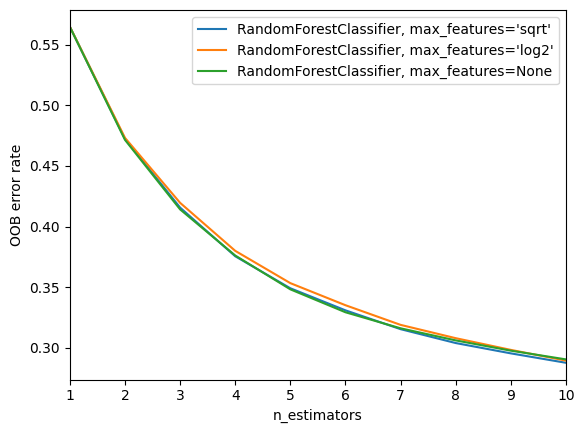

In [247]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 123

X = X_encoded
y = y_encoded

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 1
max_estimators = 10

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

Optimal Cutoff: [0.71]
Accuracy: 0.6817568327522213
AUC: 0.7973613457793141
Log Loss: 0.4379562386684362
Confusion Matrix:
 [[3674 1333]
 [4326 8449]]
Recall: 0.6613698630136986
Precision: 0.8637292987119198


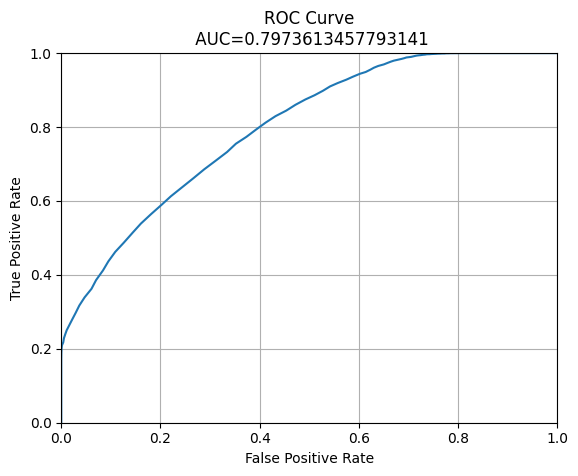

In [248]:
rf = RandomForestClassifier(n_estimators=100, 
                            criterion='gini', 
                            max_features='sqrt',
                            n_jobs=-1)
model_training(rf, X_train, y_train)

plot_auc_curve(rf, X_test, y_test)
Find_Optimal_Cutoff(rf, X_test, y_test)
print_accuracy_metrics(rf, X_test, y_test, 0.73)

Optimal Cutoff: [0.71]
Accuracy: 0.6766392981666854
AUC: 0.7910032412548069
Log Loss: 0.4437154658924264
Confusion Matrix:
 [[3704 1303]
 [4447 8328]]
Recall: 0.6518982387475538
Precision: 0.8647077146713736


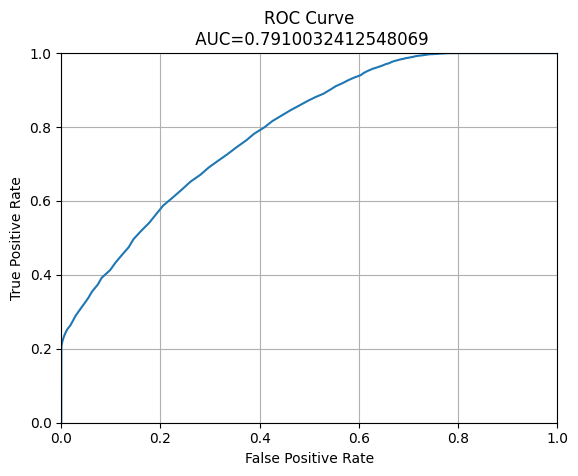

In [249]:
rf = RandomForestClassifier(n_estimators=100, 
                            criterion='gini', 
                            max_features=None,
                            n_jobs=-1)
model_training(rf, X_train, y_train)

plot_auc_curve(rf, X_test, y_test)
Find_Optimal_Cutoff(rf, X_test, y_test)
print_accuracy_metrics(rf, X_test, y_test, 0.73)

In [250]:
print_accuracy_metrics(rf, X_train, y_train, 0.73)

Accuracy: 0.9952056913083823
AUC: 1.0
Log Loss: 0.12125027077561751
Confusion Matrix:
 [[20164     0]
 [  341 50621]]
Recall: 0.9933087398453749
Precision: 1.0


Feature Importance

Feature ranking:
1. Credit_Score (0.222839)
2. Current_Loan_Amount (0.141059)
3. Maximum_Open_Credit (0.089557)
4. Monthly_Debt (0.088675)
5. Current_Credit_Balance (0.085126)
6. Years_of_Credit_History (0.082474)
7. Annual_Income (0.077743)
8. Number_of_Open_Accounts (0.050911)
9. Months_since_last_delinquent (0.047715)
10. Years_in_current_job (0.036921)
11. Term_Short Term (0.024322)
12. Home_Ownership_Rent (0.006201)
13. Home_Ownership_Home Mortgage (0.006125)
14. Number_of_Credit_Problems (0.006090)
15. Purpose_Debt Consolidation (0.005939)
16. Purpose_Other (0.004859)
17. Bankruptcies (0.004849)
18. Home_Ownership_Own Home (0.004228)
19. Purpose_Home Improvements (0.003510)
20. Tax_Liens (0.002419)
21. Purpose_Medical Bills (0.001951)
22. Purpose_Buy a Car (0.001443)
23. Purpose_Buy House (0.001230)
24. Purpose_small_business (0.000975)
25. Purpose_Take a Trip (0.000825)
26. Purpose_major_purchase (0.000703)
27. Purpose_moving (0.000402)
28. Purpose_vacation (0.000366)
29. Purpos

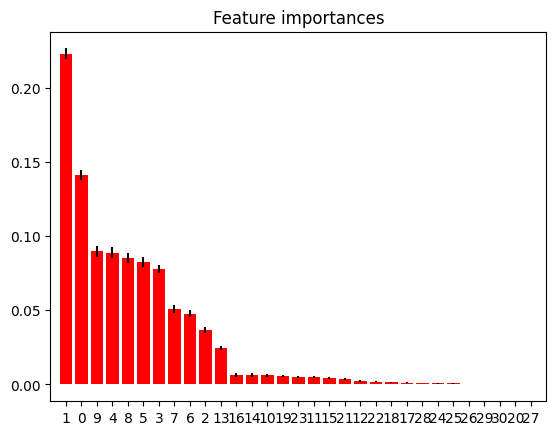

In [251]:
feature_importance(rf, X_train)

Optimal Cutoff: [0.71]
Accuracy: 0.6795073670003374
AUC: 0.795088558991971
Log Loss: 0.4366802897939062
Confusion Matrix:
 [[3712 1295]
 [4404 8371]]
Recall: 0.6552641878669276
Precision: 0.8660252431202152


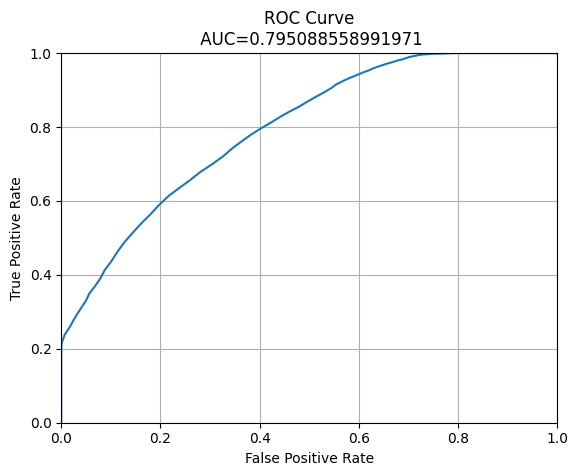

In [252]:
rf_poly = RandomForestClassifier(n_estimators=100, 
                            criterion='gini', 
                            max_features='sqrt',
                            n_jobs=-1)
model_training(rf_poly, X_train_poly, y_train)

plot_auc_curve(rf_poly, X_test_poly, y_test)
Find_Optimal_Cutoff(rf_poly, X_test_poly, y_test)
print_accuracy_metrics(rf_poly, X_test_poly, y_test, 0.73)

Bagging

Optimal Cutoff: [0.8]
Accuracy: 0.6484647396243393
AUC: 0.7663708772493459
Log Loss: 0.9002706944927837
Confusion Matrix:
 [[3684 1323]
 [4928 7847]]
Recall: 0.6142465753424657
Precision: 0.8557251908396947


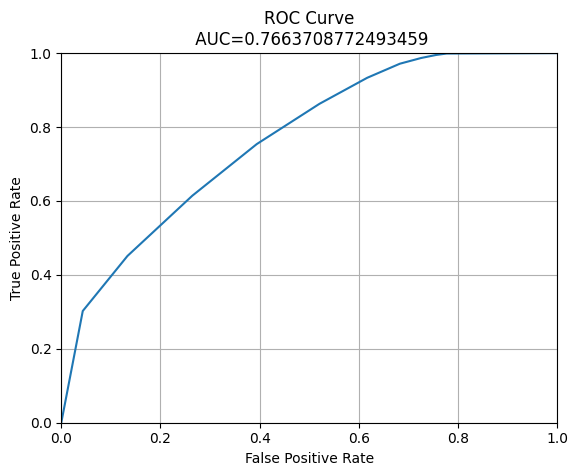

In [253]:
bagging = RandomForestClassifier(n_estimators=10, 
                            criterion='gini', 
                            max_features=None,
                            n_jobs=-1)
model_training(bagging, X_train, y_train)

plot_auc_curve(bagging, X_test, y_test)
Find_Optimal_Cutoff(bagging, X_test, y_test)
print_accuracy_metrics(bagging, X_test, y_test, 0.73)

In [254]:
print_accuracy_metrics(bagging, X_train, y_train, 0.73)

Accuracy: 0.947459438180131
AUC: 0.9993481851354118
Log Loss: 0.1286166970059962
Confusion Matrix:
 [[20150    14]
 [ 3723 47239]]
Recall: 0.9269455672854283
Precision: 0.9997037225149726


Boosting

Optimal Cutoff: [0.50220576]
Accuracy: 0.2815768754920706
AUC: 0.8022008092779697
Log Loss: 0.6564135187775232
Confusion Matrix:
 [[ 5007     0]
 [12775     0]]
Recall: 0.0
Precision: 0.0


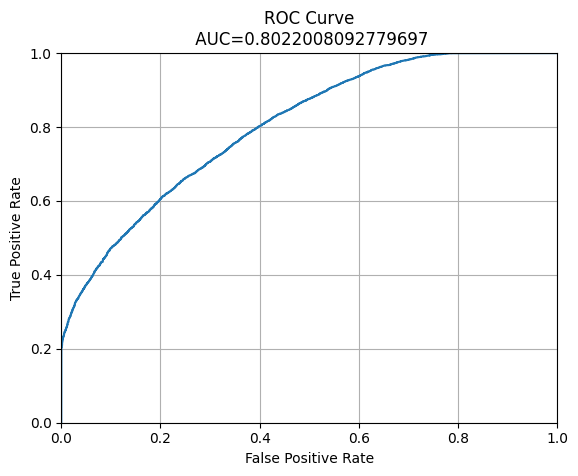

In [255]:
adaBoost = AdaBoostClassifier(n_estimators=100)
model_training(adaBoost, X_train, y_train)

plot_auc_curve(adaBoost, X_test, y_test)
Find_Optimal_Cutoff(adaBoost, X_test, y_test)
print_accuracy_metrics(adaBoost, X_test, y_test, 0.73)

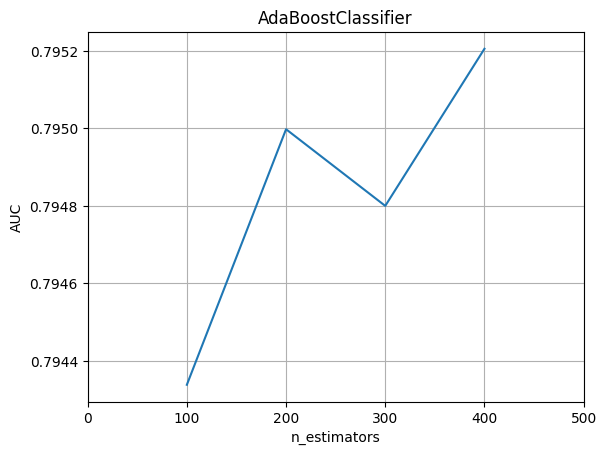

In [256]:
n_range = np.arange(100, 500, 100)
scores = []
for n in n_range:
  adaBoost = AdaBoostClassifier(n_estimators=n)
  scores.append(cross_val_score(adaBoost, X_train, y_train, cv=5, scoring='roc_auc').mean())


plt.plot(n_range, scores)
plt.xlim([0.0, 500])
#plt.ylim([0.0, 1.0])
plt.title('AdaBoostClassifier')
plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.grid(True)

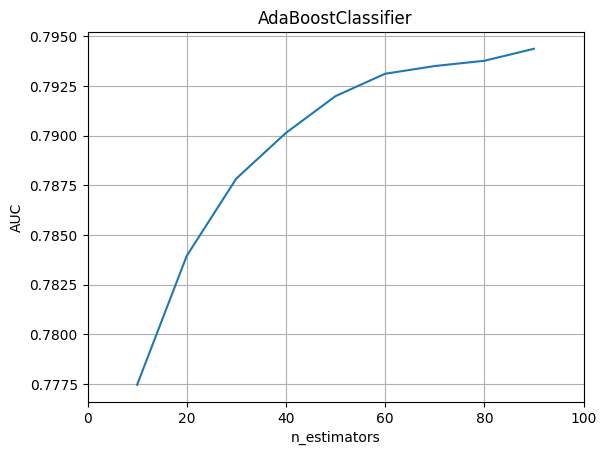

In [257]:
n_range = np.arange(10, 100, 10)
scores = []
for n in n_range:
  adaBoost = AdaBoostClassifier(n_estimators=n)
  scores.append(cross_val_score(adaBoost, X_train, y_train, cv=5, scoring='roc_auc').mean())


plt.plot(n_range, scores)
plt.xlim([0.0, 100])
#plt.ylim([0.0, 1.0])
plt.title('AdaBoostClassifier')
plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.grid(True)

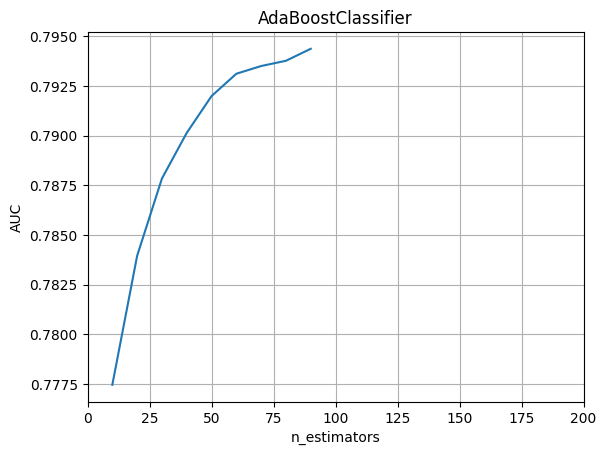

In [258]:
plt.plot(n_range, scores)
plt.xlim([0.0, 200])
#plt.ylim([0.0, 1.0])
plt.title('AdaBoostClassifier')
plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.grid(True)